In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import casadi
import os
import sys

### Optimal OPEX

In [61]:
def optimal_opex(max_storage, max_Q_HP, forecasts):

    # Unpack forecasts and get parameters
    N = forecasts['horizon']
    elec = forecasts['elec']
    load = forecasts['load']
    COP_list = [round(1/(2.695868 - 0.008533*(temp+273)),2) for temp in forecasts['T_OA']]
    min_Q_HP = max_Q_HP*0.2

    # Initialize    
    opti = casadi.Opti('conic')
 
    # -----------------------------
    # Variables and solver
    # -----------------------------
    
    Q_stor = opti.variable(1,N+1)   # state
    Q_HP = opti.variable(1,N)       # input
    delta_HP = opti.variable(1,N)   # input
    Q_HP_onoff = opti.variable(1,N) # input (derived)
    
    # delta_HP is a discrete variable (binary)
    discrete_var = [0]*(N+1) + [0]*N + [1]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete':discrete_var, 'gurobi.OutputFlag':0})

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial Q_stor level
    opti.subject_to(Q_stor[0] == 0)

    # Constraints at every time step
    for t in range(N+1):

        # Bounds on storage
        opti.subject_to(Q_stor[t] >= 0)
        opti.subject_to(Q_stor[t] <= max_storage)

        if t < N:
            
            # System dynamics
            opti.subject_to(Q_stor[t+1] == Q_stor[t] + Q_HP_onoff[t] - load[t])
    
            # Bounds on delta_HP
            opti.subject_to(delta_HP[t] >= 0)
            opti.subject_to(delta_HP[t] <= 1)
        
            # Bounds on Q_HP
            opti.subject_to(Q_HP[t] <= max_Q_HP)    
            opti.subject_to(Q_HP[t] >= min_Q_HP*delta_HP[t])
        
            # Bilinear to linear
            opti.subject_to(Q_HP_onoff[t] <= max_Q_HP*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] >= min_Q_HP*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] <= Q_HP[t] + min_Q_HP*(delta_HP[t]-1))
            opti.subject_to(Q_HP_onoff[t] >= Q_HP[t] + max_Q_HP*(delta_HP[t]-1))
    
    # -----------------------------
    # Objective
    # -----------------------------
    
    obj = sum(Q_HP_onoff[t]*elec[t]/COP_list[t] for t in range(N))
    opti.minimize(obj)

    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sys.stdout = open(os.devnull, 'w')
    sol = opti.solve()
    sys.stdout = sys.__stdout__

    Q_opt = sol.value(Q_HP_onoff)
    stor_opt = sol.value(Q_stor)
    HP_on_off_opt = sol.value(delta_HP)
    obj_opt = round(sol.value(obj)/100,3)

    return obj_opt

### Estimated CAPEX

In [62]:
def estimated_capex(storage_size, heatpump_size, lifetime):
    
    A = [5,8,12,16]
    C = [1984,2235,3257,3616]
    C_polyfit = np.polyfit(A, C, 2)
    capex_HP = np.polyval(C_polyfit, storage_size)

    A = [6, 9, 12]
    C = [2416, 2857, 3297]
    C_polyfit = np.polyfit(A, C, 2)
    capex_TES = np.polyval(C_polyfit, heatpump_size)

    capex = capex_HP + capex_TES

    interest_rate = 0# 0.05
    present_value = capex/((1+interest_rate)**lifetime)

    capex_daily = present_value / (365*lifetime)

    return round(capex_daily,3)

### Typical forecasts

In [63]:
df = pd.read_excel(os.getcwd()+'/data/gridworks_yearly_data.xlsx', header=3, index_col = 0)
df.index = pd.to_datetime(df.index)
df.index.name = None
df['elec'] = df['Total Delivered Energy Cost ($/MWh)']
df['load'] = df['House Power Required AvgKw']
df['T_OA'] = df['Outside Temp F']
df = df[['elec', 'load', 'T_OA']]
df.head()

,elec,load,T_OA
2022-01-01 00:00:00,69.39,5.91,25
2022-01-01 01:00:00,64.75,5.77,26
2022-01-01 02:00:00,63.84,5.67,27
2022-01-01 03:00:00,63.31,5.77,26
2022-01-01 04:00:00,63.17,5.71,26


In [64]:
loads = {}
for j in range(1,13):
    loads[f'month{j}'] = []
    for i in range(24):
        loads[f'month{j}'].append(0.75*np.median(list(df[(df.index.month==j) & (df.index.hour == i)].load)))

T_OAs = {}
for j in range(1,13):
    T_OAs[f'month{j}'] = []
    for i in range(24):
        T_OAs[f'month{j}'].append(np.median(list(df[(df.index.month==j) & (df.index.hour == i)].T_OA))) 

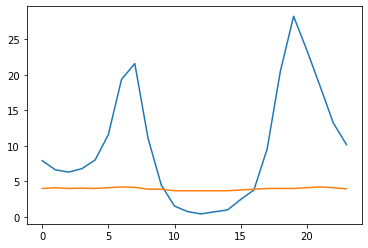

In [71]:
typical_days = []

for i in range(1,13):

    forecasts = {
        'horizon': 24,
        'elec': [7.92, 6.63, 6.31, 6.79, 8.01, 11.58, 19.38, 21.59, 11.08, 4.49, 1.52, 0.74, 0.42, 0.71, 0.97, 2.45, 3.79, 9.56, 20.51, 28.26, 23.49, 18.42, 13.23, 10.17],
        'load': loads[f'month{i}'],
        'T_OA': T_OAs[f'month{i}'],
    }

    typical_days.append(forecasts)

typical_days = [typical_days[1]]

plt.plot(forecasts['elec'])
plt.plot(forecasts['load'])
plt.show()

### Get optimal TOTEX for different equipment sizes

In [66]:
def daily_totex(storage_size, heatpump_size, lifetime, forecasts):
    totex=0
    for forecasts in typical_days:

        try:
            capex = estimated_capex(storage_size, heatpump_size, lifetime)
            opex = optimal_opex(storage_size, heatpump_size, forecasts)
            totex += capex + opex
            
        except Exception as e:
            return np.nan

    return totex

In [67]:
lifetime = 20
storage_range = np.linspace(2, 50, 15)
heatpump_range = np.linspace(2, 35, 15)
storage_grid, heatpump_grid = np.meshgrid(storage_range, heatpump_range)

cost_values = np.vectorize(daily_totex, excluded=['lifetime', 'forecasts'])(storage_grid, heatpump_grid, lifetime, forecasts)

Function solver_qpsol (0x7fd8add09400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.4479, 1.24157, 1.23483, 1.41458, 1.77212, 2.614, 4.28761, 4.22505, 2.02559, 0.725363, 0.200264, 0.103787, 0.0517241, 0.0844233, 0.111239, 0.29132, 0.515646, 1.46401, 3.05208, 4.4434, 4.19464, 3.13265, 2.25, 1.85923]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

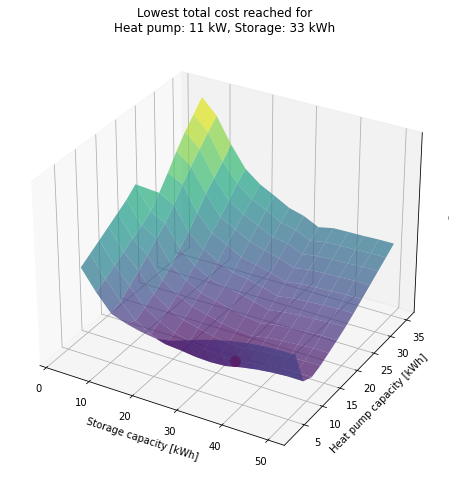

In [73]:
min_index = np.unravel_index(np.nanargmin(cost_values), cost_values.shape)
min_storage_value = storage_grid[min_index]
min_heatpump_value = heatpump_grid[min_index]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

surface = ax.plot_surface(storage_grid, heatpump_grid, cost_values, cmap='viridis', alpha=0.7)
ax.scatter(min_storage_value, min_heatpump_value, cost_values[min_index], color='red', s=100)

ax.set_title(f'Lowest total cost reached for\nHeat pump: {round(min_heatpump_value)} kW, Storage: {round(min_storage_value)} kWh')
ax.set_xlabel('Storage capacity [kWh]')
ax.set_ylabel('Heat pump capacity [kWh]')
ax.set_zlabel('Cost')
ax.set_zticks([])

plt.show()